# Laplace's Equation in a Circle

Variational Form:

$$
A(v, u) = - \int_\Omega \nabla v \cdot \nabla u \, dx, \quad F(v; f) = \int_\Omega v f \, dx
$$

Where 

$$
\Omega = \left\{x \in \mathbb{R}^2 : \left|\left|x\right|\right| < 1\right\}, \quad
\left.u\right|_{\partial \Omega} = 1
$$

Example: let 

$$
f(x) = 1 - ||x||^2
$$



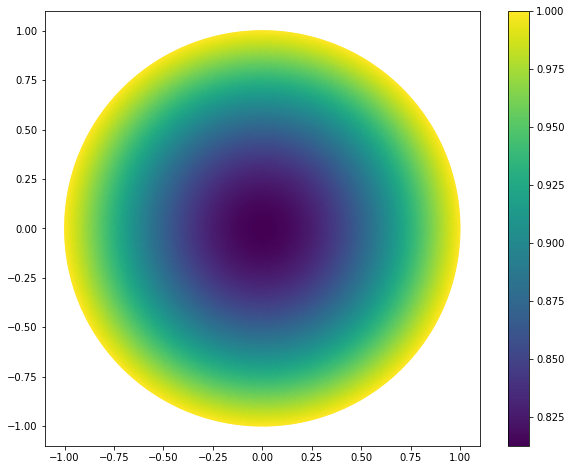

In [7]:
# imports 
from fenics import *
from mshr import *   # meshing utility
import matplotlib.pyplot as plt    # plotting

Ω = Circle(Point(0, 0), 1.0)

N = 100   # N is like 1 / Δx
mesh = generate_mesh(Ω, N)

V = FunctionSpace(mesh, "CG", 1)

u = TrialFunction(V)
v = TestFunction(V)

bc = DirichletBC(V, Constant(1.0), "on_boundary")

f_expr = Expression("1 - pow(x[0], 2) - pow(x[1], 2)", degree=1)
f = project(f_expr, V)  # have to evaluate on function space

# variational form
A = -dot(grad(v), grad(u)) * dx
F = v * f * dx

# solve
u_sol = Function(V)
solve(A == F, u_sol, bc)

plt.figure(figsize=(10, 8))
fig = plot(u_sol, mode="color")
plt.colorbar(fig)

plt.show()

## Fancy Plotting

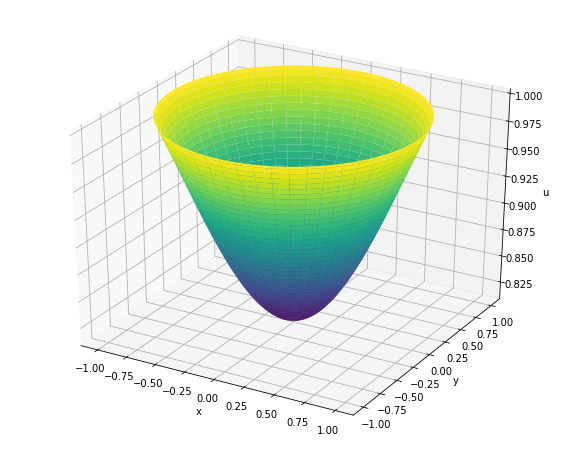

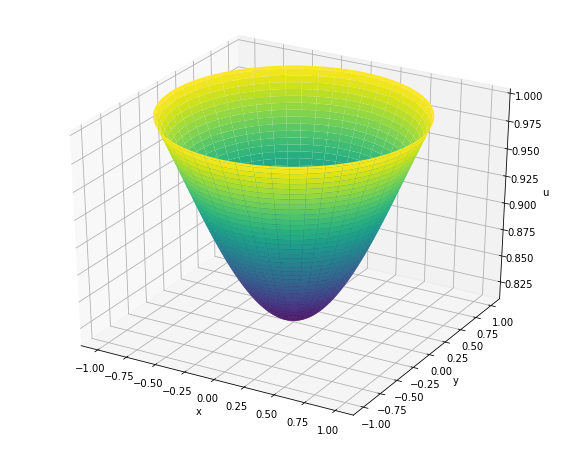

error
0.002391921356439196


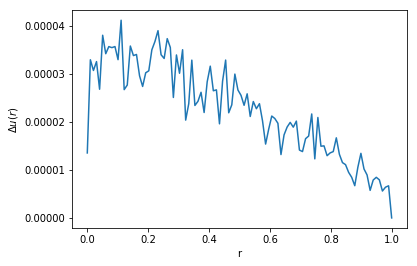

In [11]:
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

θ = np.linspace(0, 2*np.pi, 100)
r = np.linspace(0, 1, 100)
Θ, R = np.meshgrid(θ, r)

# exact solution
u_exact = lambda r: 13 / 16 + np.power(r, 2) / 4 - np.power(r, 4) / 16

X, Y = R * np.cos(Θ), R * np.sin(Θ)
U = np.zeros(np.shape(R))
u_sol.set_allow_extrapolation(True)
[m, n] = np.shape(U)
for i in range(m):
    for j in range(n):
        x, y = X[i, j], Y[i, j]
        U[i, j] = u_sol(x, y)

U_exact = u_exact(R)

fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, U,cmap='viridis', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u')
plt.savefig("fenics-laplace-circle.pdf")
plt.show()

fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, U_exact ,cmap='viridis', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u')
#plt.savefig("fenics-laplace-circle.pdf")
plt.show()

print("error")
print(np.linalg.norm(U - U_exact))

# 1D comparison
x = np.linspace(0, 1, 100)
y = 0
u = np.array(list(map(lambda x: u_sol(x, y), x)))

plt.figure()
plt.plot(x, np.abs(u - u_exact(x)), label="error")
plt.xlabel("r")
plt.ylabel("$\Delta u(r)$")
plt.show()

## Laplace's Equation in a complicated Geometry

Let $\Omega$ be a rectangle $\left[a, b\right] \times \left[c, d\right]$, with a circle centered at the origin with radius 1 removed.  Let $S_c$ be the boundary of the circle, and $S_r$ be the outer boundary of the rectangle.  We wish to solve the following problem

$$
\nabla^2 u = 0, \quad x \in \Omega, \quad \left.\frac{\partial u}{\partial n}\right|_{x\in S_r} = 0, 
\quad \left. u\right|_{x\in S_c} = f(x)
$$

Variational form, trial function $v$ such that $v = 0$ for all $ x \in S_c$.

$$
\int_\Omega v \nabla^2 u \, dx = \int_{\partial \Omega} v \frac{\partial u}{\partial n} \, d\sigma - 
\int_\Omega \nabla v \cdot \nabla u \, dx = 
\int_{S_r} v (0) \, d\sigma - \int_\Omega \nabla v \cdot \nabla u \, dx = 
-\int_\Omega \nabla v \cdot \nabla u \, dx = A
$$

$$
\int_\Omega v\nabla^2 u \, dx = \int_\Omega v (0) \, dx = 0
$$

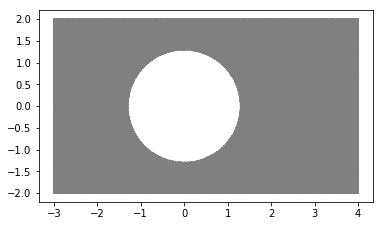

In [79]:
from fenics import *
from mshr import *
import matplotlib.pyplot as plt

TOL = 1e-3
a = -3
b = 4
c = -2
d = 2

R = 1.3

N = 100

Ω = Rectangle(Point(a, c), Point(b, d)) - Circle(Point(0, 0), R)
mesh = generate_mesh(Ω, N)

plot(mesh)
plt.show()

f = Expression("sin(x[0])", degree=2)

def circle_boundary(x, on_boundary):
    normx = sqrt(pow(x[0], 2) + pow(x[1], 2))
    return normx <= 1.5 and on_boundary

In [87]:
class Piecewise(UserExpression):
    def __init__(self, a, b, c, d, tol):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.tol = tol
        super().__init__()
    
    def eval(self, values, x):
        if abs(x[1] - self.d) < tol or abs(x[1] - self.c) < tol:
            values[0] = 0
        else:
            values[0] = (cos(self.a) * (self.b - x[0]) - cos(self.b) * (x[0] - self.a)) / (self.b - self.a)
    def value_shape(self):
        return ()
    
h = Piecewise(a, b, c, d, TOL)

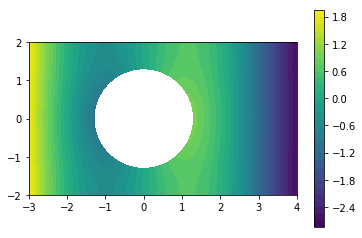

In [89]:
V = FunctionSpace(mesh, "CG", 1)
f_proj = project(f, V)
g = -div(grad(f_proj))

u = TrialFunction(V)
v = TestFunction(V)

A = -dot(grad(v), grad(u)) * dx
F = v * g * dx + v * h * ds

bc = DirichletBC(V, Constant(0.0), circle_boundary)

u_sol = Function(V)

solve(A==F, u_sol, bc)

true_sol = u_sol + f_proj
fig = plot(true_sol)
plt.colorbar(fig)
plt.show()